In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [4]:
def DFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [5]:
def BM_H_win(x):
    N = x.shape[0]
    a0 = 0.3635819
    a1 = 0.4891775
    a2 = 0.1365995
    a3 = 0.0106411
    return a0 - a1*np.cos((2*np.pi*x)/N) + a2*np.cos((4*np.pi*x)/N) - a3*np.cos((6*np.pi*x)/N)

In [6]:
def FFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N % 2 > 0:
        raise ValueError("must be a power of 2")
    elif N <= 2:
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        terms = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + terms[:int(N/2)] * X_odd,
                               X_even + terms[int(N/2):] * X_odd])

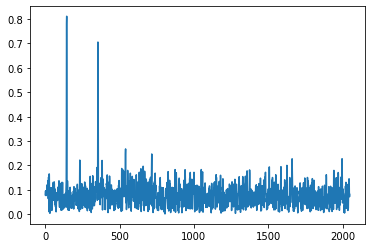

In [16]:
fs = 4096
L = 1
t = np.linspace(0,L,fs*L)

noise = random.randn(fs*L)*2

f1 = 143.5
f2 = 354.3
s = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)*0.8 + noise

win = BM_H_win(np.arange(L*fs))
out = 2*np.abs(FFT(s*win))/(np.sum(win))
out = out[0: int(L*fs/2)]

fr = np.linspace(0,int(fs/2),int((L*fs)/2))
plt.plot(fr, out)

In [27]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return np.asarray(signals)

    #return dict(signals = np.asarray(signals),
    #            avgFilter = np.asarray(avgFilter),
    #            stdFilter = np.asarray(stdFilter))

In [72]:
def findPeak(x, thresh):
    lag = 10
    influence = 1
    return thresholding_algo(x, lag, thresh, influence)


In [29]:
nspd = 2*np.abs(FFT(noise*win)/(np.sum(win)))
nspd = 4*np.sum(nspd[0:int(fs*L)])/(fs*L)
print(nspd)

0.3125453211643086


[142.06936981 143.06985833 354.172936  ]


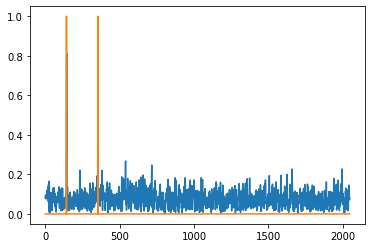

In [73]:
peaks = findPeak(out, 7)
print(fr[peaks >0])

plt.plot(out)
plt.plot(peaks)

In [79]:
fp = peaks > 0
freqPeaks = fr[fp]
freqWin1 = fr*0
freqWin2 = fr*0
print(freqPeaks[0])
freqWin1[freqPeaks[0]-25: freqPeaks[0]+25] = BM_H_win(np.arange(50))
freqWin2[freqPeaks[2]-25: freqPeaks[2]+25] = BM_H_win(np.arange(50))+freqPeaks[2]
filtOut = out*(freqWin1 + freqWin2)
plt.plot(filtOut)

142.06936980947728


TypeError: slice indices must be integers or None or have an __index__ method